In [196]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from model.MyIBL import MyIBL
from sklearn.model_selection import GridSearchCV, KFold

from MyFeatureSelection import MyFeatureSelection
from helperFunctions import *
from modelsAnalysis import *
from sklearn.metrics import roc_curve


In [2]:
trainData, testData, df_train, labels, df_test, labels_test = runPreprocessing('all', outliers=True)

traintest
data/train.csv
data/test.csv
process_type: all
(Number of outliers, threshold) (3, 133.65)
process_type: all


In [3]:
# AN - AN for  Feature Selection - chooses 35 dimensions - for feeding IBL
num_dim_AN = 35
an_train, an_test = MyFeatureSelection.AnovaSelection(df_train, df_test, labels, num_dim_AN)
ibl = MyIBL(n_neighbors=13, ibl_algo='ib2', voting='mvs', distance='euclidean')
ibl.fit(an_train, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": ibl.predict(an_test)}).to_csv(
#    './submissions/ibl.csv', index=False)
df_ens_feature1, ens_test1 = ensemble(ibl, an_train, labels, an_test)

In [5]:
# IG - Information Gain for  Feature Selection - chooses 25 dimensions - for feeding Random Forest
num_dim_IG_RF = 25
ig_train_RF, ig_test_RF = MyFeatureSelection.InfoGainSelection(df_train, df_test, labels, num_dim_IG_RF)
rfc = RandomForestClassifier(criterion='gini', max_depth=80, max_features='log2', min_samples_leaf=3, min_samples_split=10, n_estimators=100)
rfc.fit(ig_train_RF, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": rfc.predict(ig_test_RF)}).to_csv('./submissions/rfc.csv', index=False)
df_ens_feature2, ens_test2 = ensemble(rfc, ig_train_RF, labels, ig_test_RF)

In [6]:
# ICA - ICA for  Feature Selection - chooses 20 dimensions - for feeding MLP
num_dim_ICA = 20
ica_train, ica_test = MyFeatureSelection.applyICA(df_train, df_test, num_dim_ICA)
net = MLPClassifier(max_iter=1000, activation='relu', hidden_layer_sizes=11, learning_rate='invscaling', learning_rate_init=0.001, solver='lbfgs')
net.fit(ica_train, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": net.predict(ica_test)}).to_csv('./submissions/mlp.csv', index=False)
df_ens_feature3, ens_test3 = ensemble(net, ica_train, labels, ica_test)

In [7]:
# LR - Lasso Regression for  Feature Selection - chooses 18 dimensions - for feeding XGBoost
alpha_XGB = 0.003
lr_train_XGB, lr_test_XGB = MyFeatureSelection.LassoRegressionSelection(df_train, df_test, labels, alpha_XGB)
xgb = XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=150, objective='binary:logistic', subsample=0.6)
xgb.fit(lr_train_XGB, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": xgb.predict(lr_test_XGB)}).to_csv('./submissions/xgb.csv', index=False)
df_ens_feature4, ens_test4 = ensemble(xgb, lr_train_XGB, labels, lr_test_XGB)

In [8]:
# LR - Lasso Regression for  Feature Selection - chooses 30 dimensions - for feeding LDA
alpha_LDA = 0.0009
lr_train_LDA, lr_test_LDA = MyFeatureSelection.LassoRegressionSelection(df_train, df_test, labels, alpha_LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(lr_train_LDA, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": lda.predict(lr_test_LDA)}).to_csv('./submissions/lda.csv', index=False)
df_ens_feature5, ens_test5 = ensemble(lda, lr_train_LDA, labels, lr_test_LDA)

In [9]:
# IG - Information Gain for  Feature Selection - chooses 45 dimensions - for feeding SVC
num_dim_IG_SVC = 45
ig_train_SVC, ig_test_SVC = MyFeatureSelection.InfoGainSelection(df_train, df_test, labels, num_dim_IG_SVC)
svc = SVC(C=1, gamma=0.1, kernel='rbf')
svc.fit(ig_train_SVC, labels)
#pd.DataFrame({"PassengerId": testData["PassengerId"], "Survived": svc.predict(ig_test_SVC)}).to_csv('./submissions/svc.csv', index=False)
df_ens_feature6, ens_test6 = ensemble(svc, ig_train_SVC, labels, ig_test_SVC)

In [10]:
# PCA - PCA for  Feature Selection - chooses 19 dimensions - for feeding KNN
num_dim_PCA = 19
pca_train, pca_test, ev = MyFeatureSelection.applyPCA(df_train, df_test, num_dim_PCA)
knn = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=13, weights='uniform')
knn.fit(pca_train, labels)
df_ens_feature7, ens_test7 = ensemble(knn, pca_train, labels, pca_test)

# Build ensemble model

In [11]:
df_ens_features = pd.concat([df_ens_feature1, df_ens_feature2, df_ens_feature3, df_ens_feature4, df_ens_feature5, df_ens_feature6, df_ens_feature7], axis=1)
df_ens_test = pd.concat([ens_test1, ens_test2, ens_test3, ens_test4, ens_test5, ens_test6, ens_test7], axis=1)

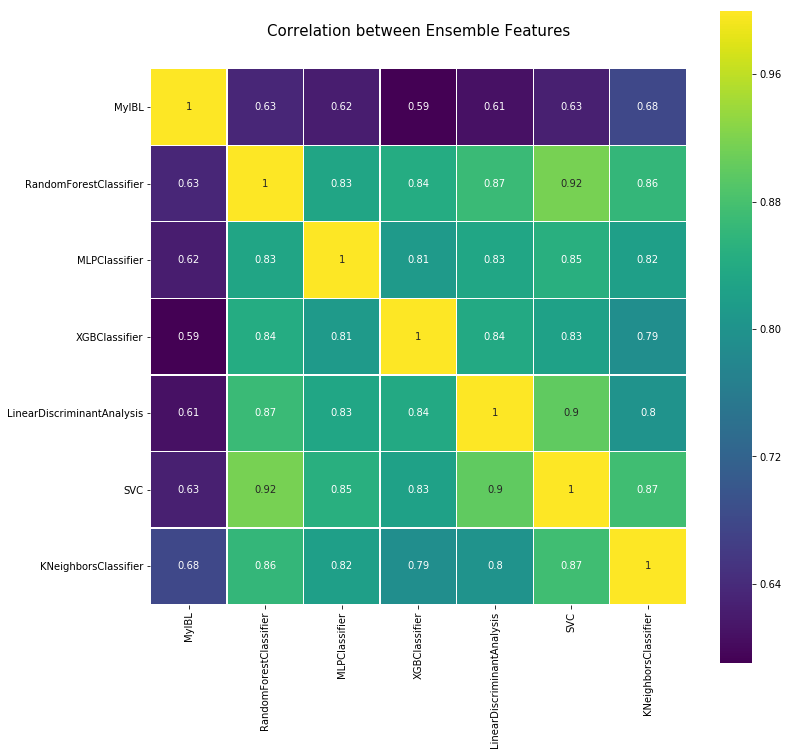

In [12]:
correlation_fig(df_ens_features)

In [106]:
print(df_ens_features.columns)

def ensemble_build(features):
    df_ens = df_ens_features[features]
    df_test = df_ens_test[features]
    train_idx, validation_idx = get_cv_data(df_ens, cv=5)
    clfs = [XGBClassifier()]
    model_ens, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)
    return model_ens, df_model_info_ens

Index(['MyIBL', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier', 'LinearDiscriminantAnalysis', 'SVC', 'KNeighborsClassifier'], dtype='object')



XGBClassifier
XGBClassifier 0.8434710848727226 accuracy at validation stage, 0.22015595436096191 s


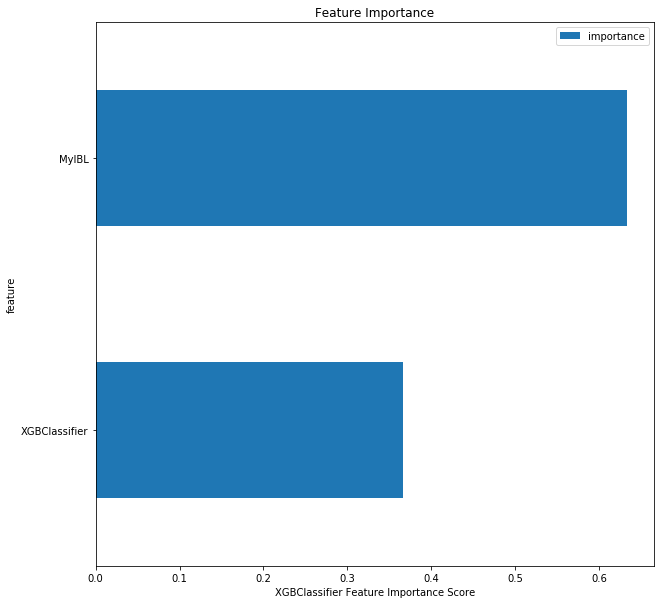


XGBClassifier
XGBClassifier 0.8277026598108297 accuracy at validation stage, 0.1891341209411621 s


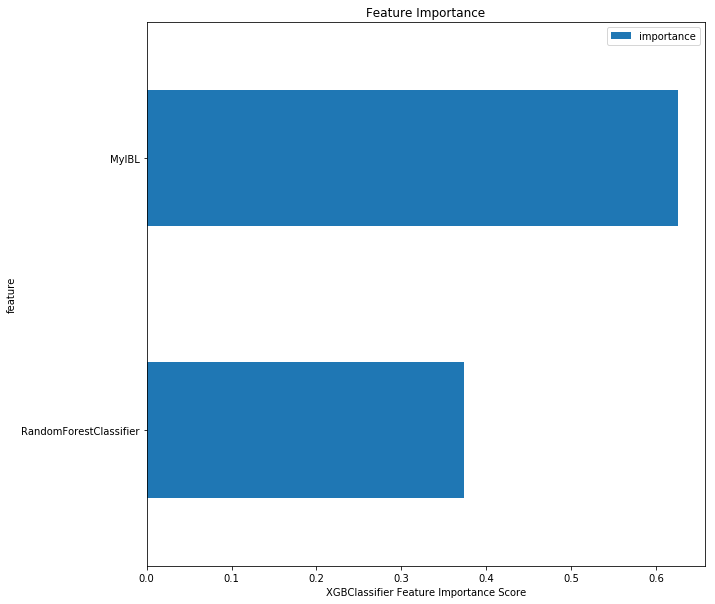


XGBClassifier
XGBClassifier 0.8310924903193043 accuracy at validation stage, 0.1781458854675293 s


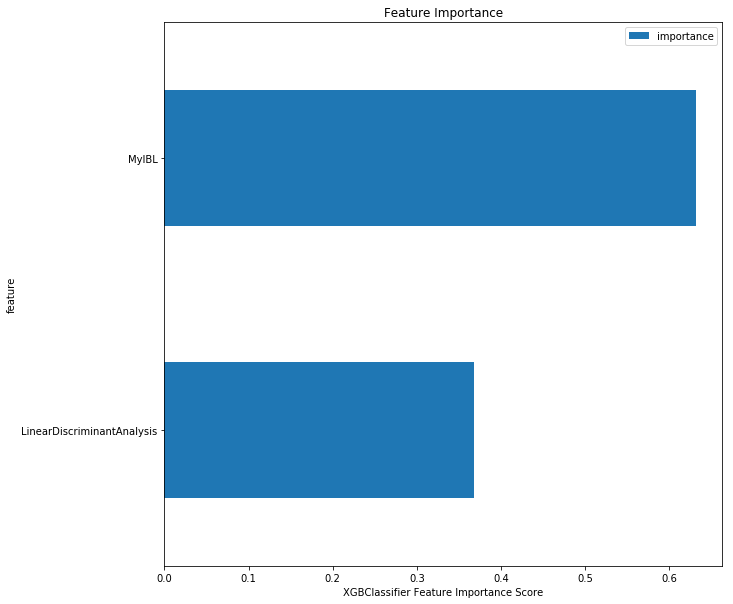


XGBClassifier
XGBClassifier 0.8265917602996254 accuracy at validation stage, 0.18512940406799316 s


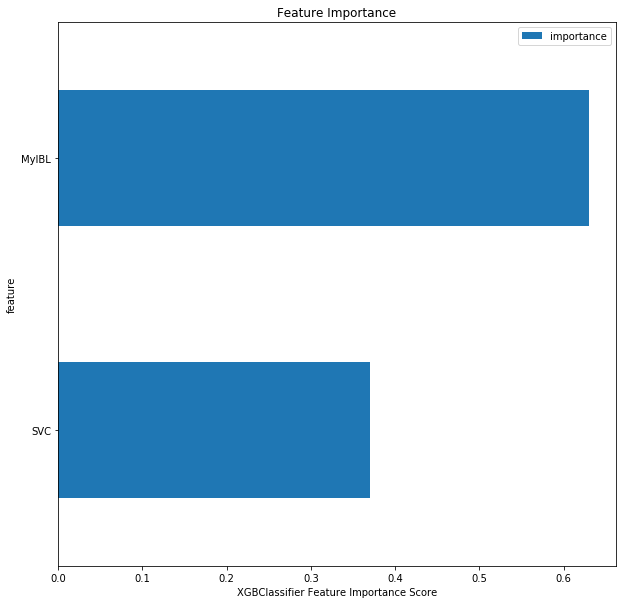


XGBClassifier
XGBClassifier 0.8277090078080366 accuracy at validation stage, 0.15913081169128418 s


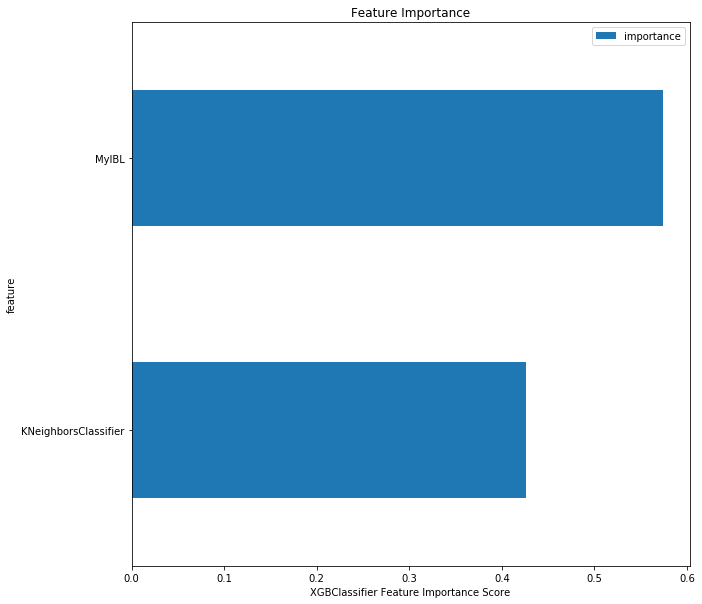


XGBClassifier
XGBClassifier 0.8164920967434774 accuracy at validation stage, 0.16013050079345703 s


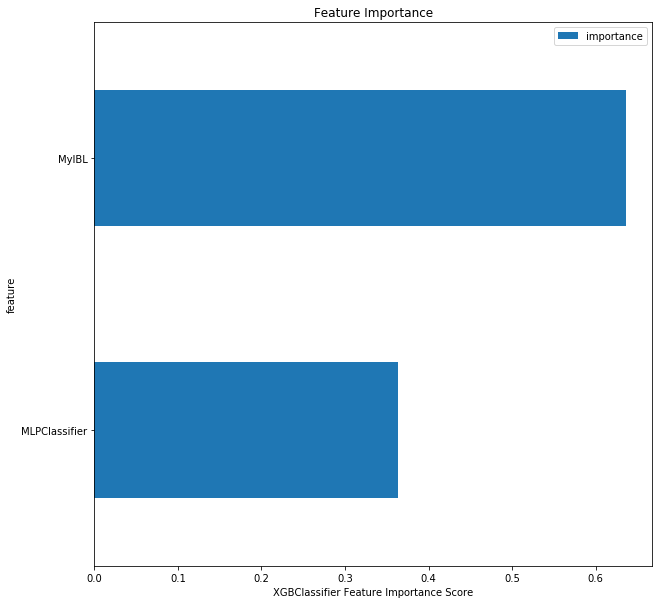


XGBClassifier
XGBClassifier 0.8243382212911826 accuracy at validation stage, 0.15712928771972656 s


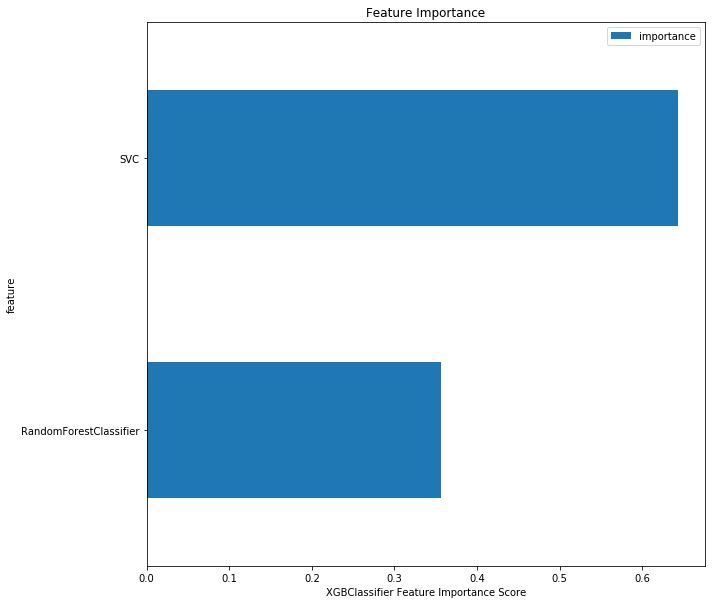


XGBClassifier
XGBClassifier 0.8288452993080683 accuracy at validation stage, 0.18312978744506836 s


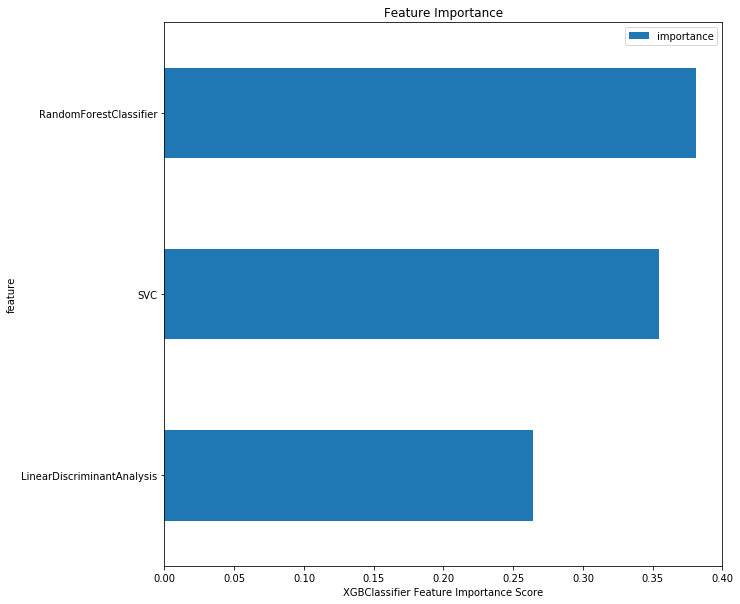

In [119]:
features_list = [['MyIBL', 'XGBClassifier'], ['MyIBL', 'RandomForestClassifier'],
                 ['MyIBL', 'LinearDiscriminantAnalysis'], ['MyIBL', 'SVC'],
                 ['MyIBL', 'KNeighborsClassifier'], ['MyIBL', 'MLPClassifier'],
                 ['SVC', 'RandomForestClassifier'], ['SVC', 'RandomForestClassifier', 'LinearDiscriminantAnalysis']]
df = pd.DataFrame()
for features in features_list:
    model, df_model_info_ens = ensemble_build(features)
    df = pd.concat([df, df_model_info_ens])


In [123]:
df.index = ['IBL-XGB', 'IBL-RF', 'IBL-LDA', 'IBL-SVM', 'IBL-KNN', 'IBL-MLP', 'SVM-RF', 'SVM-RF-LDA']

In [124]:
df

,Accuracy,Duration
IBL-XGB,0.843471,0.044031
IBL-RF,0.827703,0.037827
IBL-LDA,0.831092,0.035629
IBL-SVM,0.826592,0.037026
IBL-KNN,0.827709,0.031826
IBL-MLP,0.816492,0.032026
SVM-RF,0.824338,0.031426
SVM-RF-LDA,0.828845,0.036626


No handles with labels found to put in legend.


(0.78, 0.85)

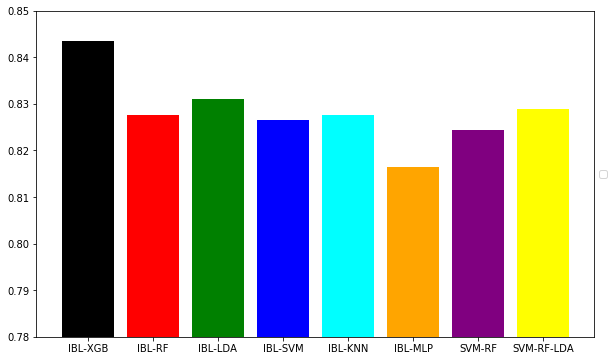

In [188]:
plt.figure(figsize=(10, 6))
height = df.Accuracy.values
bars = acc_df.index.values
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=['black', 'red', 'green', 'blue', 'cyan', 'orange', 'purple', 'yellow'])

plt.xticks(y_pos, bars)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(0.78, 0.85)

In [144]:
acc_df.transpose().values.tolist()

[[0.8434710848727226,
  0.8277026598108297,
  0.8310924903193043,
  0.8265917602996254,
  0.8277090078080366,
  0.8164920967434774,
  0.8243382212911826,
  0.8288452993080683]]

In [190]:
param_ranges = {
    'objective' : ['binary:logistic', 'binary:hinge'],
    'n_estimators' : [50, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth' : [2, 4, 5, 6, 7, 12],
    'learning_rate' : [0.3, 0.1, 0.01, 0.001, 0.0001],
    'subsample' : [0.2, 0.5, 0.6],
    'colsample_bytree' : [0.2, 0.5, 0.6]
}

xgb = XGBClassifier()
cv = KFold(n_splits=5)
grid_search = GridSearchCV(xgb, param_ranges, cv=cv, scoring="accuracy", n_jobs=3, verbose=2)

grid_search.fit(df_ens_features[['MyIBL', 'XGBClassifier']], labels)

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 515 tasks      | elapsed:   26.7s
[Parallel(n_jobs=3)]: Done 1124 tasks      | elapsed:   57.0s
[Parallel(n_jobs=3)]: Done 1812 tasks      | elapsed:  1.8min
[Parallel(n_jobs=3)]: Done 2616 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 3855 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 5403 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 6955 tasks      | elapsed:  6.3min
[Parallel(n_jobs=3)]: Done 9343 tasks      | elapsed:  8.4min
[Parallel(n_jobs=3)]: Done 12239 tasks      | elapsed: 10.6min
[Parallel(n_jobs=3)]: Done 15367 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 18687 tasks      | elapsed: 15.8min
[Parallel(n_jobs=3)]: Done 22127 tasks      | elapsed: 18.6min
[Parallel(n_jobs=3)]: Done 24300 out of 24300 | elapsed: 20.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'objective': ['binary:logistic', 'binary:hinge'], 'n_estimators': [50, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 5, 6, 7, 12], 'learning_rate': [0.3, 0.1, 0.01, 0.001, 0.0001], 'subsample': [0.2, 0.5, 0.6], 'colsample_bytree': [0.2, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [191]:
print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best params:  {'colsample_bytree': 0.2, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 0.2}
Best score:  0.8434684684684685


Index(['MyIBL', 'RandomForestClassifier', 'MLPClassifier', 'XGBClassifier', 'LinearDiscriminantAnalysis', 'SVC', 'KNeighborsClassifier'], dtype='object')

XGBClassifier
XGBClassifier 0.8434710848727226 accuracy at validation stage, 0.08814620971679688 s


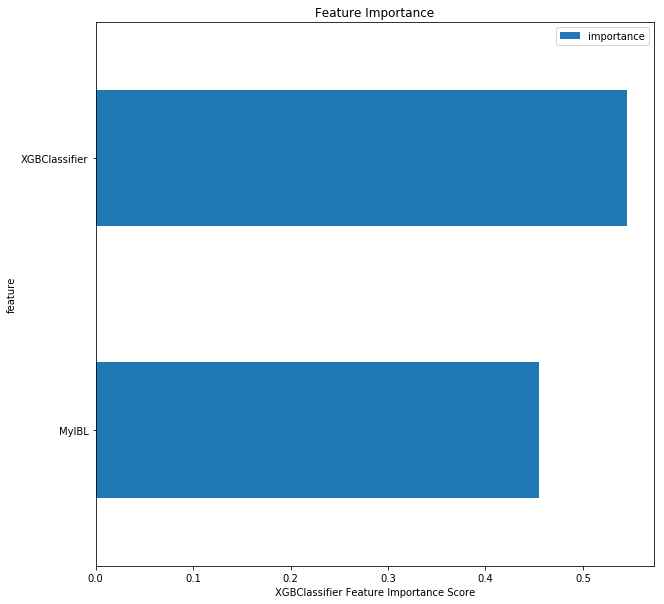

In [193]:
print(df_ens_features.columns)
df_ens = df_ens_features[['MyIBL', 'XGBClassifier']]
df_test = df_ens_test[['MyIBL', 'XGBClassifier']]
train_idx, validation_idx = get_cv_data(df_ens, cv=5)
clfs = [XGBClassifier(
        colsample_bytree=0.2, learning_rate=0.3, max_depth=4, n_estimators=50, objective='binary:logistic', subsample=0.2)]
model_ens, _, df_model_info_ens, _, _ = run_models(clfs, df_ens, labels, df_test, train_idx, validation_idx, cv=True, ens=False)

In [206]:
model_ens[0].score(df_test, labels_test)

0.7655502392344498

In [199]:
fpr_1, tpr_1, _ = roc_curve(labels, df_ens_feature1)
fpr_2, tpr_2, _ = roc_curve(labels, df_ens_feature2)
fpr_3, tpr_3, _ = roc_curve(labels, df_ens_feature3)
fpr_4, tpr_4, _ = roc_curve(labels, df_ens_feature4)
fpr_5, tpr_5, _ = roc_curve(labels, df_ens_feature5)
fpr_6, tpr_6, _ = roc_curve(labels, df_ens_feature6)
fpr_7, tpr_7, _ = roc_curve(labels, df_ens_feature7)

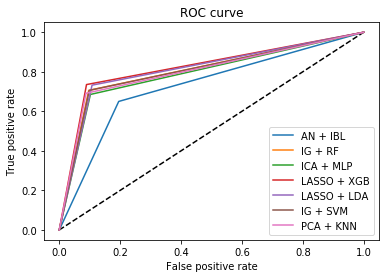

In [205]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='AN + IBL')
plt.plot(fpr_2, tpr_2, label='IG + RF')
plt.plot(fpr_3, tpr_3, label='ICA + MLP')
plt.plot(fpr_4, tpr_4, label='LASSO + XGB')
plt.plot(fpr_5, tpr_5, label='LASSO + LDA')
plt.plot(fpr_6, tpr_6, label='IG + SVM')
plt.plot(fpr_7, tpr_7, label='PCA + KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()